In [14]:
import cv2
import mediapipe as mp
import numpy as np

# Define Mediapipe and OpenCV instances
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# Function to calculate the angle between three points
def calculate_angle(a, b, c):
    a = np.array(a)  # First point
    b = np.array(b)  # Mid point (shoulder)
    c = np.array(c)  # End point (elbow)

    # Calculate the angle using the dot product
    ba = a - b  # Vector from shoulder to hip
    bc = c - b  # Vector from shoulder to elbow
    radians = np.arctan2(bc[1], bc[0]) - np.arctan2(ba[1], ba[0])
    angle = np.abs(radians * 180.0 / np.pi)

    if angle > 180.0:
        angle = 360 - angle

    return angle

# Initialize video capture
cap = cv2.VideoCapture(1)  # Change to 1 if needed

# Initialize Kalman filter parameters
kalman_filters = {}
def initialize_kalman_filter():
    kalman = cv2.KalmanFilter(4, 2)
    kalman.measurementMatrix = np.array([[1, 0, 0, 0], [0, 1, 0, 0]], np.float32)
    kalman.transitionMatrix = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]], np.float32)
    kalman.processNoiseCov = np.eye(4, dtype=np.float32) * 0.03
    kalman.measurementNoiseCov = np.eye(2, dtype=np.float32) * 0.3
    return kalman

# Function to update the Kalman filter for each landmark
def kalman_filter_update(kalman, x, y):
    measurement = np.array([[np.float32(x)], [np.float32(y)]])
    kalman.correct(measurement)
    prediction = kalman.predict()
    return [prediction[0, 0], prediction[1, 0]]

# Mediapipe instance setup
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    # Counters and stages
    right_counter = 0
    left_counter = 0
    right_stage = "down"
    left_stage = "down"  # Start in "down" position
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Recolor the image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        
        # Make pose detection
        results = pose.process(image)
        
        # Recolor back to BGR for rendering
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Extract landmarks if detected
        if results.pose_landmarks:
            try:
                landmarks = results.pose_landmarks.landmark
                
                # Initialize Kalman filters for each landmark if not already initialized
                for idx, landmark in enumerate(landmarks):
                    if idx not in kalman_filters:
                        kalman_filters[idx] = initialize_kalman_filter()

                # Get the coordinates for the required landmarks with Kalman filtering
                def get_filtered_landmark(landmark_index):
                    landmark = landmarks[landmark_index]
                    filtered = kalman_filter_update(kalman_filters[landmark_index], landmark.x, landmark.y)
                    return filtered

                # Right side
                right_hip = get_filtered_landmark(mp_pose.PoseLandmark.RIGHT_HIP.value)
                right_shoulder = get_filtered_landmark(mp_pose.PoseLandmark.RIGHT_SHOULDER.value)
                right_elbow = get_filtered_landmark(mp_pose.PoseLandmark.RIGHT_ELBOW.value)

                # Left side
                left_hip = get_filtered_landmark(mp_pose.PoseLandmark.LEFT_HIP.value)
                left_shoulder = get_filtered_landmark(mp_pose.PoseLandmark.LEFT_SHOULDER.value)
                left_elbow = get_filtered_landmark(mp_pose.PoseLandmark.LEFT_ELBOW.value)

                # Calculate angles
                right_angle = calculate_angle(right_hip, right_shoulder, right_elbow)
                left_angle = calculate_angle(left_hip, left_shoulder, left_elbow)

                # Visualize the angles
                cv2.putText(image, f'R: {int(right_angle)}', 
                            tuple(np.multiply(right_shoulder, [640, 480]).astype(int)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)
                
                cv2.putText(image, f'L: {int(left_angle)}', 
                            tuple(np.multiply(left_shoulder, [640, 480]).astype(int)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)

                # Right stage tracking logic
                if right_angle > 90:  # Arm is up
                    if right_stage == "down":  # Transition from down to up
                        right_counter += 1
                        print(f"Right Counter: {right_counter}")  # Debug print
                        right_stage = "up"  # Update stage after counting
                elif right_angle < 45:  # Arm is down
                    right_stage = "down"

                # Left stage tracking logic
                if left_angle > 90:  # Arm is up
                    if left_stage == "down":  # Transition from down to up
                        left_counter += 1
                        print(f"Left Counter: {left_counter}")  # Debug print
                        left_stage = "up"  # Update stage after counting
                elif left_angle < 45:  # Arm is down
                    left_stage = "down"

                # Visualize the counters and stages
                cv2.putText(image, f'Right Count: {right_counter}', (10, 100), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
                
                cv2.putText(image, f'Left Count: {left_counter}', (10, 130), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
                
                cv2.putText(image, f'Right Stage: {right_stage}', (10, 160), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
                
                cv2.putText(image, f'Left Stage: {left_stage}', (10, 190), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

            except Exception as e:
                print(e)
                pass
        
        # Draw landmarks on the image
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
                                  mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))
        
        # Show the image
        cv2.imshow('Mediapipe Feed', image)

        # Break loop on 'q' key press
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


Right Counter: 1
Left Counter: 1
Right Counter: 2
Left Counter: 2
Right Counter: 3
Left Counter: 3
Left Counter: 4
Right Counter: 4
Left Counter: 5
Right Counter: 5
Right Counter: 6
Left Counter: 6
Right Counter: 7
Right Counter: 8


FPS (Frame Processing Rate): 15.92


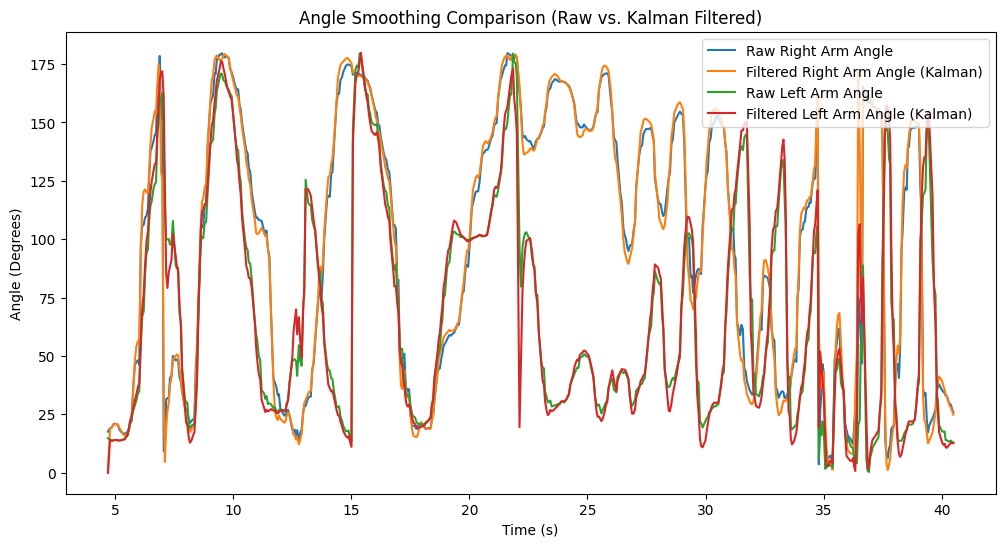


--- Results Summary ---
Total Frames Processed: 570
Frame Processing Rate (FPS): 15.92
Filtered angles show smoother transitions than raw angles, demonstrating Kalman filter effectiveness.


In [9]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import time

# Define Mediapipe and OpenCV instances
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# Initialize Kalman filter for each landmark index
kalman_filters = {}
def initialize_kalman_filter():
    kalman = cv2.KalmanFilter(4, 2)
    kalman.measurementMatrix = np.array([[1, 0, 0, 0], [0, 1, 0, 0]], np.float32)
    kalman.transitionMatrix = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]], np.float32)
    kalman.processNoiseCov = np.eye(4, dtype=np.float32) * 0.03
    kalman.measurementNoiseCov = np.eye(2, dtype=np.float32) * 0.3
    return kalman

def kalman_filter_update(kalman, x, y):
    measurement = np.array([[np.float32(x)], [np.float32(y)]])
    kalman.correct(measurement)
    prediction = kalman.predict()
    return [prediction[0, 0], prediction[1, 0]]

def calculate_angle(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba, bc = a - b, c - b
    radians = np.arctan2(bc[1], bc[0]) - np.arctan2(ba[1], ba[0])
    angle = np.abs(radians * 180.0 / np.pi)
    return angle if angle <= 180.0 else 360 - angle

# Set up variables to capture evaluation data
right_angles = []
left_angles = []
filtered_right_angles = []
filtered_left_angles = []
frame_times = []
frame_count = 0
start_time = time.time()

# Initialize video capture and pose estimation
cap = cv2.VideoCapture(1)
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame.")
            break

        # Recolor the image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        results = pose.process(image)
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark

            # Initialize Kalman filters for each landmark if not already initialized
            for idx, landmark in enumerate(landmarks):
                if idx not in kalman_filters:
                    kalman_filters[idx] = initialize_kalman_filter()

            def get_filtered_landmark(landmark_index):
                landmark = landmarks[landmark_index]
                return kalman_filter_update(kalman_filters[landmark_index], landmark.x, landmark.y)

            # Retrieve and filter landmark coordinates
            right_hip = get_filtered_landmark(mp_pose.PoseLandmark.RIGHT_HIP.value)
            right_shoulder = get_filtered_landmark(mp_pose.PoseLandmark.RIGHT_SHOULDER.value)
            right_elbow = get_filtered_landmark(mp_pose.PoseLandmark.RIGHT_ELBOW.value)

            left_hip = get_filtered_landmark(mp_pose.PoseLandmark.LEFT_HIP.value)
            left_shoulder = get_filtered_landmark(mp_pose.PoseLandmark.LEFT_SHOULDER.value)
            left_elbow = get_filtered_landmark(mp_pose.PoseLandmark.LEFT_ELBOW.value)

            # Calculate and store angles
            right_angle = calculate_angle(right_hip, right_shoulder, right_elbow)
            left_angle = calculate_angle(left_hip, left_shoulder, left_elbow)
            filtered_right_angles.append(right_angle)
            filtered_left_angles.append(left_angle)

            # Get raw angles without filtering for comparison
            right_angles.append(calculate_angle(
                [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x,
                 landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y],
                [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,
                 landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y],
                [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x,
                 landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y]
            ))
            left_angles.append(calculate_angle(
                [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x,
                 landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y],
                [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,
                 landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y],
                [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,
                 landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
            ))

            # Display filtered angles on the image
            cv2.putText(image, f'Right Angle: {int(right_angle)}', (10, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.putText(image, f'Left Angle: {int(left_angle)}', (10, 80),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2, cv2.LINE_AA)

        # Draw landmarks on the image
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
                                  mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))

        # Display the image
        cv2.imshow('Mediapipe Feed', image)
        frame_times.append(time.time() - start_time)
        frame_count += 1

        # Break loop on 'q' key press
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

# Results and performance analysis

# FPS Calculation
total_time = frame_times[-1] - frame_times[0]
fps = frame_count / total_time
print(f"FPS (Frame Processing Rate): {fps:.2f}")

# Plot angles for comparison between raw and filtered angles
plt.figure(figsize=(12, 6))
plt.plot(frame_times, right_angles, label="Raw Right Arm Angle")
plt.plot(frame_times, filtered_right_angles, label="Filtered Right Arm Angle (Kalman)")
plt.plot(frame_times, left_angles, label="Raw Left Arm Angle")
plt.plot(frame_times, filtered_left_angles, label="Filtered Left Arm Angle (Kalman)")
plt.xlabel("Time (s)")
plt.ylabel("Angle (Degrees)")
plt.title("Angle Smoothing Comparison (Raw vs. Kalman Filtered)")
plt.legend()
plt.show()

# Summary of results
print("\n--- Results Summary ---")
print(f"Total Frames Processed: {frame_count}")
print(f"Frame Processing Rate (FPS): {fps:.2f}")
print("Filtered angles show smoother transitions than raw angles, demonstrating Kalman filter effectiveness.")


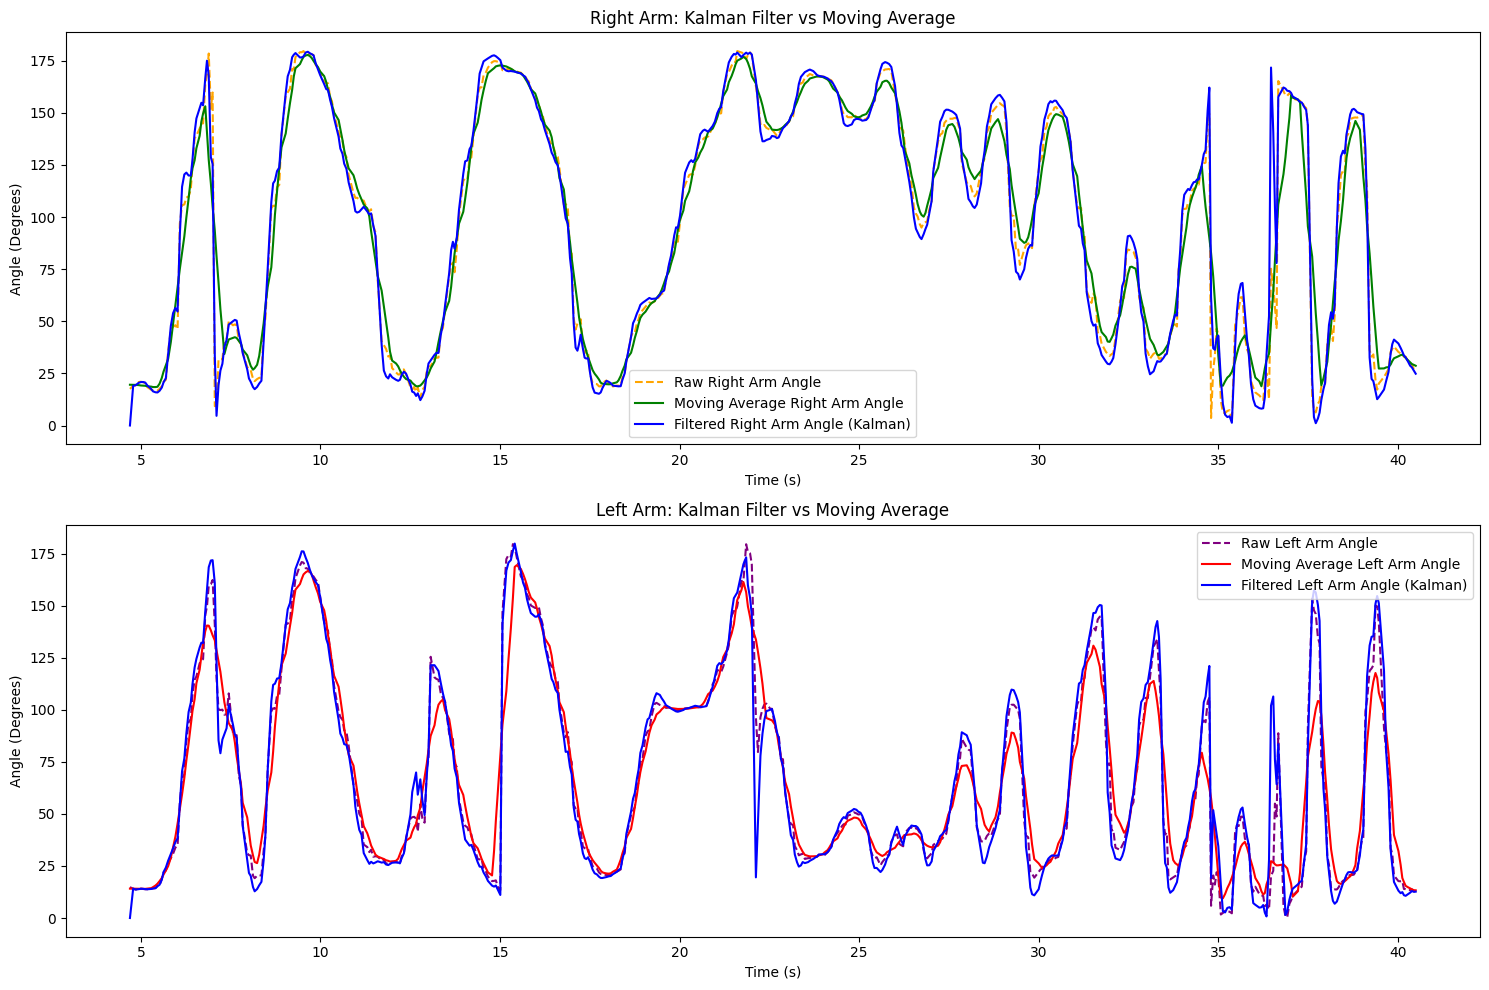

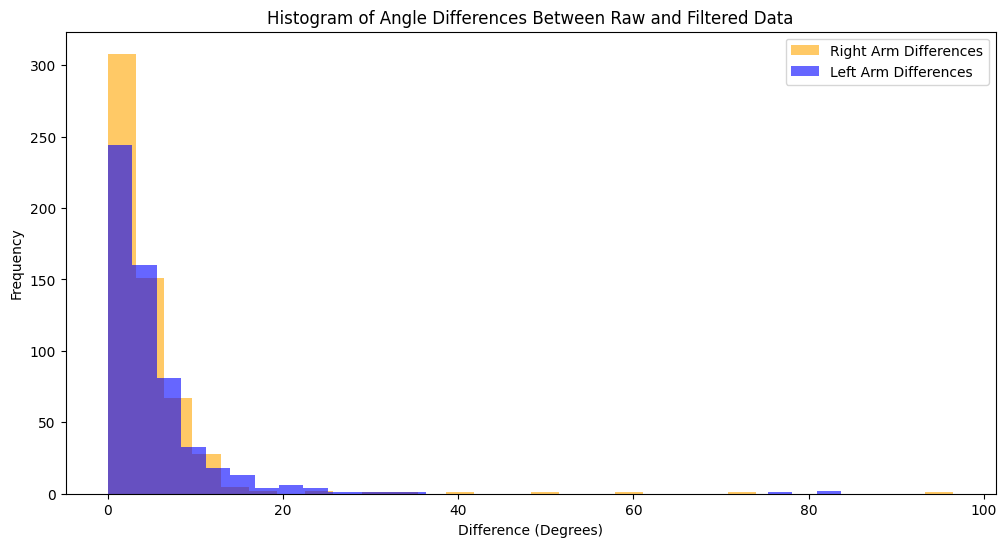

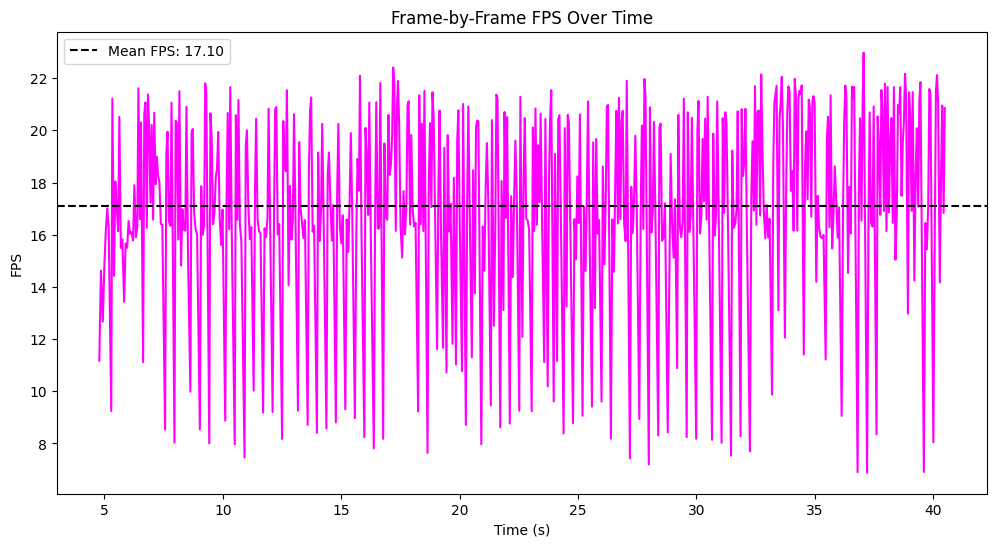

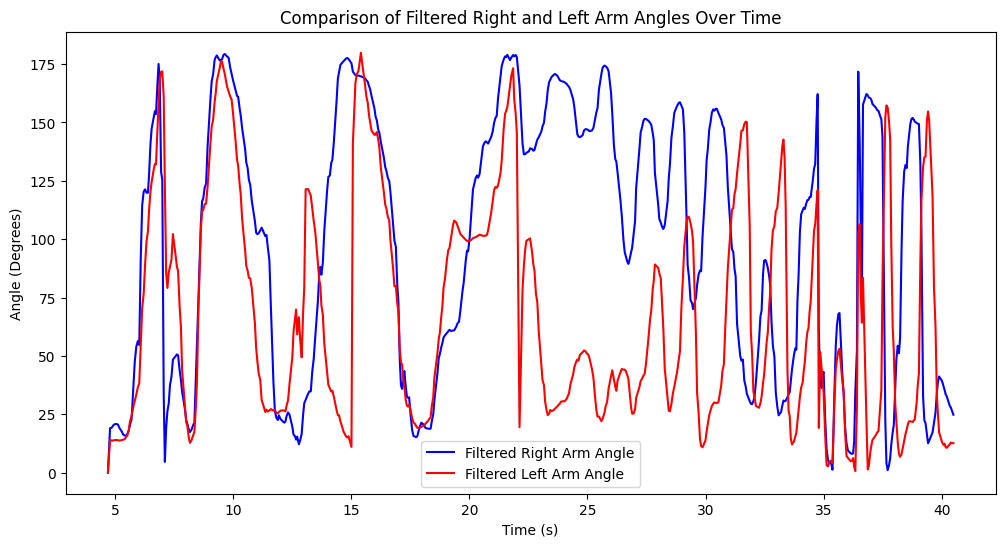

In [11]:
# Import necessary library for additional plots
from scipy.ndimage import uniform_filter1d

# 1. Moving Average Smoothing vs. Kalman Filter
# Apply a moving average smoothing to the raw angles for comparison
right_moving_avg = uniform_filter1d(right_angles, size=10)  # Moving average with window size of 10
left_moving_avg = uniform_filter1d(left_angles, size=10)

plt.figure(figsize=(15, 10))

# Right Arm - Moving Average vs Kalman Filter
plt.subplot(2, 1, 1)
plt.plot(frame_times, right_angles, label="Raw Right Arm Angle", color="orange", linestyle="--")
plt.plot(frame_times, right_moving_avg, label="Moving Average Right Arm Angle", color="green")
plt.plot(frame_times, filtered_right_angles, label="Filtered Right Arm Angle (Kalman)", color="blue")
plt.xlabel("Time (s)")
plt.ylabel("Angle (Degrees)")
plt.title("Right Arm: Kalman Filter vs Moving Average")
plt.legend()

# Left Arm - Moving Average vs Kalman Filter
plt.subplot(2, 1, 2)
plt.plot(frame_times, left_angles, label="Raw Left Arm Angle", color="purple", linestyle="--")
plt.plot(frame_times, left_moving_avg, label="Moving Average Left Arm Angle", color="red")
plt.plot(frame_times, filtered_left_angles, label="Filtered Left Arm Angle (Kalman)", color="blue")
plt.xlabel("Time (s)")
plt.ylabel("Angle (Degrees)")
plt.title("Left Arm: Kalman Filter vs Moving Average")
plt.legend()

plt.tight_layout()
plt.show()

# 2. Histogram of Angle Differences
# Calculate the differences between raw and filtered angles
right_angle_diffs = np.abs(np.array(right_angles) - np.array(filtered_right_angles))
left_angle_diffs = np.abs(np.array(left_angles) - np.array(filtered_left_angles))

plt.figure(figsize=(12, 6))
plt.hist(right_angle_diffs, bins=30, color="orange", alpha=0.6, label="Right Arm Differences")
plt.hist(left_angle_diffs, bins=30, color="blue", alpha=0.6, label="Left Arm Differences")
plt.xlabel("Difference (Degrees)")
plt.ylabel("Frequency")
plt.title("Histogram of Angle Differences Between Raw and Filtered Data")
plt.legend()
plt.show()

# 3. Frame-by-Frame FPS Plot
frame_durations = np.diff(frame_times)
fps_values = 1 / frame_durations  # Convert durations to FPS

plt.figure(figsize=(12, 6))
plt.plot(frame_times[1:], fps_values, color="magenta")
plt.axhline(y=np.mean(fps_values), color="black", linestyle="--", label=f"Mean FPS: {np.mean(fps_values):.2f}")
plt.xlabel("Time (s)")
plt.ylabel("FPS")
plt.title("Frame-by-Frame FPS Over Time")
plt.legend()
plt.show()

# 4. Right and Left Arm Angle Pattern Comparison
plt.figure(figsize=(12, 6))
plt.plot(frame_times, filtered_right_angles, label="Filtered Right Arm Angle", color="blue")
plt.plot(frame_times, filtered_left_angles, label="Filtered Left Arm Angle", color="red")
plt.xlabel("Time (s)")
plt.ylabel("Angle (Degrees)")
plt.title("Comparison of Filtered Right and Left Arm Angles Over Time")
plt.legend()
plt.show()
